<a href="https://colab.research.google.com/github/trsarje/AmazonMusicReview/blob/main/CountVectorize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import math

import nltk
nltk.download('punkt')
from nltk.corpus import stopwords  
from nltk.probability import FreqDist
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer 

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import gensim
from gensim.utils import simple_preprocess
import csv
import re

import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
ip_data = pd.read_csv("/content/drive/MyDrive/AmazonMusic/data/Music.csv")
data = ip_data.sample(frac=0.01, random_state=0)   # Taking a sample of data to suitable for RAM
data.head()

,productId,title,userId,review,score
3477750,B00006LI4S,David Gilmour in Concert - Live at Robert Wyat...,unknown,I bought the DVD several months ago. I had nev...,5.0
6298848,B00000IAU3,No Angel,A5OYA02OQJTMU,The voice of Dido is unbelievable talented and...,3.0
4109460,B000J234QG,Joshua Tree,A1VABWDOUQLULZ,I know it's clich&eacute;d. I know the band ha...,5.0
5651752,B000A29B2Q,In the Skies,A28OGM5C71B1XD,This is Peter's first solo release and his thi...,4.0
394058,B00001R3N7,Famous Monsters,A2S409SX8V43BJ,To those who truly believe that there is no su...,5.0


In [3]:
  lemmatizer = WordNetLemmatizer() 

In [4]:
freq_words = ["album", "cd", "would", "get", "wouldnt", "think", "buy", "dont", "even", "one", "time", "im","ablum", "id", "ooo", "oo"]

In [5]:
stop_words = set(stopwords.words('english'))  
corpus = []
for i, r in enumerate(data.review):
  r = re.sub(r'[^\w\s]', '', r)
  r = re.sub(r'[0-9]', '', r)
  r = r.split()
  rev = [lemmatizer.lemmatize(w.lower()) for w in r if w.lower() not in stop_words if w.lower() not in freq_words]
  sp = " "
  #rev = sp.join(rev)
  corpus.append(rev)

In [6]:
max_len = max([len(c) for c in corpus])
max_len

2309

In [7]:
# Count frequency of words in reviews 
def word_freq(reviwes):
  word_counts = {}
  for tokens in reviwes:
      for token in tokens:
          if token in word_counts:
              word_counts[token] += 1
          else:
              word_counts[token] = 1
              
  top_word_counts = sorted(word_counts.items(), key=lambda i: i[1], reverse=True)
  return top_word_counts, word_counts

In [16]:
# Remove words with low frequency 
WordFreq, WordFreq_dict = word_freq(corpus)
words = []
for w in WordFreq:
  if w[1] >= 11:
    words.append(w)
WordFreq = words
WordFreq[:12]

[('song', 76479),
 ('like', 43200),
 ('music', 36838),
 ('great', 31237),
 ('good', 27116),
 ('track', 24499),
 ('sound', 24332),
 ('best', 22611),
 ('love', 21821),
 ('band', 21381),
 ('first', 19137),
 ('really', 18748)]

In [9]:
WordFreq_dict.values()

dict_values([5100, 3586, 2185, 1256, 2162, 9649, 1227, 2891, 3053, 122, 1051, 555, 1028, 2150, 4500, 2275, 5399, 41, 19137, 4379, 2, 3814, 36838, 1164, 115, 411, 535, 224, 2056, 490, 999, 139, 742, 237, 426, 5417, 27116, 6496, 1639, 9383, 43200, 1, 1657, 3015, 792, 12, 45, 1, 1073, 114, 6833, 7810, 1032, 845, 4867, 24499, 5498, 4849, 1058, 3843, 76479, 1057, 504, 173, 872, 3166, 4784, 426, 59, 5, 3862, 233, 1027, 31237, 11031, 1176, 444, 23, 259, 4524, 353, 1, 6, 7897, 119, 2744, 16, 1127, 451, 186, 135, 862, 167, 4141, 39, 34, 1848, 11, 99, 3490, 6989, 8072, 13013, 2908, 3307, 802, 10442, 10350, 1609, 1109, 2008, 104, 555, 3, 5, 6, 5562, 8974, 885, 1, 678, 323, 1786, 915, 3686, 10053, 14, 312, 327, 2503, 332, 4153, 368, 6, 2, 1, 13, 14, 275, 84, 230, 1, 6383, 13261, 1, 272, 7837, 183, 1140, 3343, 168, 1153, 341, 1335, 10220, 181, 292, 1696, 11122, 339, 70, 100, 58, 22611, 1126, 3961, 91, 11333, 5, 796, 1, 755, 2034, 18, 770, 11531, 84, 16, 1350, 275, 52, 247, 1442, 8, 3, 10837, 13, 21

In [10]:
# Calculate the term frequency as (number of times "t" appear in a review/total terms in that review)
# Calculate Inverse Document frequency 
# log_e(Total number of documents / Number of documents with term t in it)

tf_matrix = []
idf_matrix = []
total_doc = len(corpus)

for i,sentense in enumerate(corpus):
  tf_score = {}
  idf_score = {}
  total_count = len(sentense)
  word_count, _ = word_freq([sentense])

  for w in word_count:
    tf_score[w[0]] = w[1]/total_count
    idf_score[w[0]] = math.log10(total_doc/w[1])
  tf_matrix.append(tf_score)
  idf_matrix.append(idf_score)

In [11]:
features = np.zeros((len(corpus),max_len))

for i in range(len(corpus)):
  tf = np.array(list(tf_matrix[i].values()))
  idf = np.array(list(idf_matrix[i].values()))

  tf_idf = np.multiply(tf, idf)
  del_l = max_len-len(tf_idf)
  zero = np.zeros((del_l,))
  features[i] = np.concatenate((tf_idf, zero), axis=0)

In [12]:
n = 2
pca = PCA(n_components=n)
pca.fit(features)
transformed = pca.transform(features)
transformed.shape

(63964, 2)

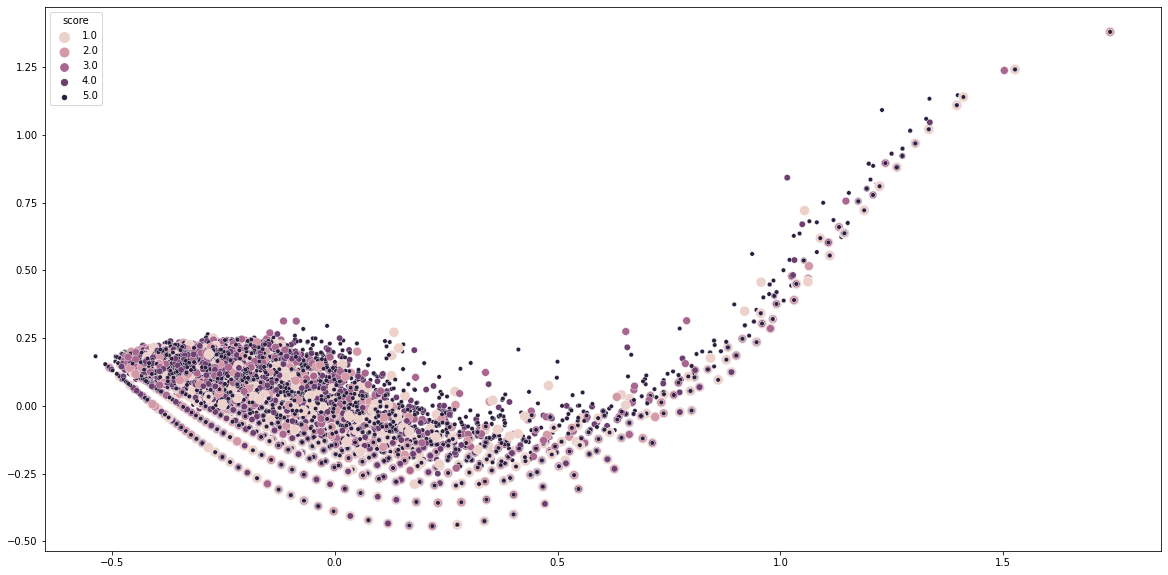

In [31]:
plt.figure(figsize=(20,10))
sns.scatterplot(x=transformed[:,0], y=transformed[:,1],hue=data.score,
                size=data.score,
                sizes=(100,20))
plt.show()